In [64]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import cv2
import pandas as pd

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import models, transforms

# Data Visualization
from PIL import Image
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualization of Paintings
from IPython.display import Image

# !pip install kornia
# !pip install grad-cam

# kornia imports
import kornia.augmentation as K
import kornia.geometry.transform as T

# Activation map
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM

seed = 211
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [65]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Data augmentation using Kornia
transform_train = K.AugmentationSequential(
    K.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.333)),
    K.RandomRotation(degrees=(-10, 10)),
    K.RandomHorizontalFlip(),
    K.RandomAffine(degrees=(0, 0), scale=(1.0, 1.1), shear=(0, 0)),  # Zoom
    K.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    same_on_batch=False
)
transform_val_test = K.AugmentationSequential(
    K.CenterCrop(size=(224, 224)),
    K.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    same_on_batch=False
)

In [66]:
def create_dataloaders(batch_size=32, data_dir=None):
    image_datasets = {x: ImageFolder(os.path.join(data_dir, x), transform=preprocess) for x in
                      ['train', 'validation', 'test']}
    train_loader = DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(image_datasets['validation'], batch_size=batch_size)
    test_loader = DataLoader(image_datasets['test'], batch_size=batch_size)
    dataloaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }
    class_names = image_datasets['train'].classes
    return image_datasets, dataloaders, class_names

In [67]:
batch_size = 32
data_dir = "./input/dataset"   # change to your directory

# Create the dataloaders
image_datasets, dataloaders, class_names = create_dataloaders(batch_size=batch_size, data_dir=data_dir)

In [68]:
def set_parameter_requires_grad(model, feature_extracting=False):
    # approach 1
    if feature_extracting:
        # frozen model
        model.requires_grad_(False)
    else:
        # fine-tuning
        model.requires_grad_(True)

In [69]:
# for LoRA/DoRA
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        # rank: controls the inner dimension of the matrices A and B; controls the number of additional parameters introduced by LoRA,
        # a key factor in determining the balance between model adaptability and parameter efficiency.
        # alpha: a scaling hyper-parameter applied to the output of the low-rank adaptation,
        # controls the extent to which the adapted layer's output is allowed to influence the original output of the layer being adapted.

        self.use_dora = use_dora
        self.rank = rank  # low-rank
        self.alpha = alpha  # scaling hyper-parameter
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))

        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T
            return F.linear(x, combined_weight, self.linear.bias)


In [70]:
def replace_linear_with_dora_lora(model, rank, alpha, use_dora=True):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            # Create a new DoRALayer with the same dimensions
            in_features = module.in_features
            out_features = module.out_features
            if in_features > 10 and out_features > 10:
                # Replace the module with the LowRankLayer
                setattr(model, name,  LowRankLayer(module, rank, alpha, use_dora=use_dora))
        else:
            # Recursively apply this function to submodules
            replace_linear_with_dora_lora(module, rank, alpha, use_dora=use_dora)

In [71]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True, DoRA=False, LoRA=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model = None
    weights = 'DEFAULT' if use_pretrained else None
    rank, alpha = 4, 8
    if model_name == "cnn_mobile_net":
        model = models.mobilenet_v3_large(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.classifier[3].in_features       # 1280
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)
        if DoRA or LoRA:
            use_dora = True if DoRA else False
            replace_linear_with_dora_lora(model, rank, alpha, use_dora=use_dora)
    elif model_name == "cnn_resnet50":
        model = models.resnet50(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vit_base_16":       # supervised visual transformer model - 86.6M params
        model = models.vit_b_16(weights=weights)
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.heads[0].in_features
        model.heads[0] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vit_dino_v2":           # self-supervised visual transformer model - 91.5M params
        model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')
        set_parameter_requires_grad(model, feature_extract)
        num_ftrs = model.linear_head.in_features
        model.linear_head = nn.Linear(num_ftrs, num_classes)

    else:
        raise NotImplementedError

    return model

## Compare the best CNN models to ViT models
We investigate the checkpoints of the following models because when we compared the CNN models, they showed the highest accuracies on the validation set.

The CNN models are: mobilenet_v3_large and resnet50

We compare the CNN models to ViT models: vit_base_16 and vit_dino_v2.

In this notebook evaluation we show the best results achieved for resnet50 and vit_dino_v2.

In [72]:
opt_models = ["cnn_mobile_net", "cnn_resnet50", "vit_base_16", "vit_dino_v2"]
CNN_model_name = opt_models[1]
ViT_model_name = opt_models[3]
num_classes = len(class_names)
num_epochs = 20
# Flag for feature extracting. When False, we fine-tune the whole model,
# when True we only update the reshaped layer params
feature_extract_list = [True, True] # [True, True] for cnn_mobile_net and vit_dino_v2
LoRA_list = [False, False]
DoRA_list = [False, False]
train_list = [False, False]

In [73]:
# training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    model = model.to(device)
    since = time.time()

    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    history = [train_loss, train_acc, val_loss, val_acc]


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Kornia augmentation
                if phase == 'train':
                    inputs = transform_train(inputs)
                else:
                    inputs = transform_val_test(inputs)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss.append(epoch_loss), train_acc.append(epoch_acc.cpu())

                # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss.append(epoch_loss), val_acc.append(epoch_acc.cpu())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [74]:
# plot the best model
def plot_test_results(hist):

    epochs = len(hist[0])

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    axes[0].plot(range(1, epochs + 1), hist[0], label='Training')
    axes[0].plot(range(1, epochs + 1), hist[2], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_title('Loss')
    axes[0].legend(loc='best')

    axes[1].plot(range(1, epochs + 1), hist[1], label='Training')
    axes[1].plot(range(1, epochs + 1), hist[3], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_title('Accuracy')
    axes[1].legend(loc='best')

    plt.tight_layout()
    plt.show()

In [75]:
best_models = [CNN_model_name, ViT_model_name]
models_save_dir = "./checkpoints"
models_save_names = []
histories_save_dir = "./histories"

if not os.path.exists(models_save_dir):
    os.makedirs(models_save_dir)

if not os.path.exists(histories_save_dir):
    os.makedirs(histories_save_dir)

history_titles = ["train_loss", "train_acc", "val_loss", "val_acc"]

In [76]:
for model in best_models:
    # get the index of the model in the list
    model_idx = best_models.index(model)
    feature_extract = feature_extract_list[model_idx]
    DoRA = DoRA_list[model_idx]
    LoRA = LoRA_list[model_idx]
    train = train_list[model_idx]
    
    # create save name for the model
    save_name = model + '_bs_' + str(batch_size) + '_ep_' + str(num_epochs)
    save_name = save_name + '_fe' if feature_extract else save_name + '_ft'
    if model == CNN_model_name:
        save_name = save_name + '_DoRA' if DoRA else save_name + '_LoRA' if LoRA else save_name
    save_name += '.pth'
    models_save_names.append(save_name)


    # Initialize the model for this run
    if model == CNN_model_name:
        model = initialize_model(model, num_classes, feature_extract,
                                                        use_pretrained=True, DoRA=DoRA, LoRA=LoRA)
    else:
        model = initialize_model(model, num_classes, feature_extract,
                                                        use_pretrained=True)

    # Print the model we just instantiated
    # print(model)

    model = model.to(device)

    params_to_update = model.parameters()
    # Observe that all parameters are being optimized
    optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    # Setup the loss fn
    criterion = nn.CrossEntropyLoss()

    if train:

        print("Params to learn:")
        if feature_extract:
            params_to_update = []  # override the initial list definition above
            for name, param in model.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    print("\t", name)
        else:
            for name, param in model.named_parameters():
                if param.requires_grad == True:
                    print("\t", name)


        # Train and evaluate
        model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

        # plot loss and accuracy
        plot_test_results(history)

        # save model
        model_save_path = os.path.join(models_save_dir, save_name)
        torch.save(model.state_dict(), model_save_path)

        # save the history in csv file with titles: train_loss, train_acc, val_loss, val_acc
        history_save_name = "history_" + model + "_" + ".csv"
        history_save_path = os.path.join(histories_save_dir, history_save_name)
        history_dict = {title: history[i] for i, title in enumerate(history_titles)}
        history_dict_df = pd.DataFrame(history_dict)
        history_dict_df.to_csv(history_save_path, index=False)


Using cache found in C:\Users\Data_Science/.cache\torch\hub\facebookresearch_dinov2_main


In [77]:
# load models
print("the best cnn model is " + models_save_names[0])
print("the best vit model is " + models_save_names[1])
CNN_weights_path = os.path.join(models_save_dir, models_save_names[0])
feature_extract = feature_extract_list[0]
CNN_best = initialize_model(best_models[0], num_classes, feature_extract, use_pretrained=True, DoRA=DoRA_list[0], LoRA=LoRA_list[0])
CNN_best.load_state_dict(torch.load(CNN_weights_path, map_location=device))

ViT_weights_path = os.path.join(models_save_dir, models_save_names[1])
feature_extract = feature_extract_list[1]
ViT_best = initialize_model(best_models[1], num_classes, feature_extract, use_pretrained=True)
ViT_best.load_state_dict(torch.load(ViT_weights_path, map_location=device))

the best cnn model is cnn_resnet50_bs_32_ep_20_fe.pth
the best vit model is vit_dino_v2_bs_32_ep_20_fe.pth


Using cache found in C:\Users\Data_Science/.cache\torch\hub\facebookresearch_dinov2_main


<All keys matched successfully>

In [78]:
# testing function
def test_model(model, test_loader, criterion):
    model = model.to(device)

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    all_preds = []
    all_probs = []

    # Iterate over data
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Kornia augmentation
        inputs = transform_val_test(inputs)

        # forward
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            # classes probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            # class prediction
            _, preds = torch.max(outputs, 1)
            # add to history
            all_preds.append(preds.detach().cpu().numpy())
            all_probs.append(probs.detach().cpu().numpy())

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)

    print('Test loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))


    return epoch_loss, epoch_acc, all_preds, all_probs

##### PREDCITIONS ON TEST DATA ######

In [79]:
test_ds = image_datasets['test']
class_names_bin = test_ds.classes
label_to_str = {index: value for index, value in enumerate(class_names_bin)}
test_file_list = test_ds.imgs
# True classes
y_true = np.array(test_ds.targets)

In [80]:
# Make predictions for each of the two models (Evaluate on the test set)
CNN_test_loss, CNN_test_acc, CNN_preds, CNN_probs = test_model(CNN_best, dataloaders['test'], criterion)
ViT_test_loss, ViT_test_acc, ViT_preds, ViT_probs = test_model(ViT_best, dataloaders['test'], criterion)

Test loss: 0.4397 Acc: 0.8723
Test loss: 0.1827 Acc: 0.9415


In [81]:
y_pred_cnn = np.concatenate(CNN_preds)
y_pred_vit = np.concatenate(ViT_preds)

y_prob_cnn = np.concatenate(CNN_probs)
y_prob_vit = np.concatenate(ViT_probs)


print('CNN model, test set accuracy: {:5.2f}%'.format(100 * CNN_test_acc))
print('ViT model, test set accuracy: {:5.2f}%'.format(100 * ViT_test_acc))

CNN model, test set accuracy: 87.23%
ViT model, test set accuracy: 94.15%


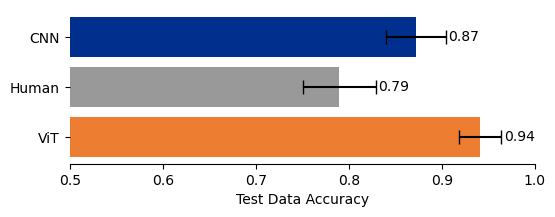

In [82]:
CNN_test_acc = CNN_test_acc.cpu().numpy()
ViT_test_acc = ViT_test_acc.cpu().numpy()

def se(x,n):
    return(np.sqrt((x*(1-x))/n))

# data
x = ["CNN", "Human", "ViT"]
y = [CNN_test_acc, 0.79, ViT_test_acc]
n = [420, 420, 420]
yerr = list(1.96*se(np.array(y),np.array(n)))
colors = ['#002F8E', '#999999', '#ED7D31']

# plot:
fig, ax = plt.subplots(figsize=(6,2))
hbars = ax.barh(x, y, xerr=yerr,
                capsize=5, align='center', color = colors)
ax.set_yticks(x, labels=x)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Test Data Accuracy')
ax.bar_label(hbars, fmt='%.2f', padding=2)
ax.set_xlim(right=1, left=0.5)  # adjust xlim to fit labels
ax.spines[['left', 'right', 'top']].set_visible(False)

plt.show()

In [83]:
# Define function to plot Confusion matrix depending on model
def plot_CM(model_name, data=test_ds):

    if model_name == "CNN":
        pred_labels = y_pred_cnn
    elif model_name == "ViT":
        pred_labels = y_pred_vit
    else:
        print("Provide either CNN or ViT as model_name.")

    acc_score = np.mean(pred_labels == y_true)
    # get the confusion plot
    cm = sklearn.metrics.confusion_matrix(y_true, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names_bin)
    return (disp)

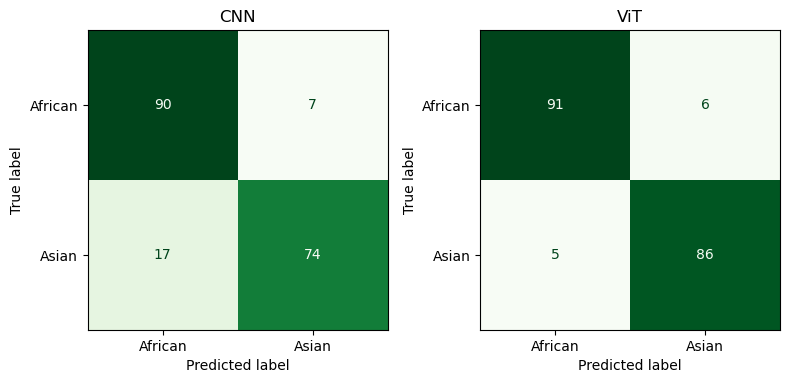

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plot_CM('CNN').plot(ax=ax[0], cmap="Greens", colorbar=False)
ax[0].set_title('CNN')
plot_CM('ViT').plot(ax=ax[1], cmap="Greens", colorbar=False)
ax[1].set_title('ViT')
plt.tight_layout()
plt.show()

In [85]:
#### PLOTTING FUNCTION
# Define a function that plots 1 test set image and their corresponding prediction
def plotting_img_by_idx(test_file_list, idx_list, n_img=1, resize=False):

    idx_list = np.array(list(idx_list))
    # get n_img random elements from the list without replacement
    idx_list = idx_list[random.sample(range(0, len(idx_list)), n_img)]

    for i in range(len(idx_list)):
        idx = idx_list[i]
        if resize:      # optional - resize all images to shape (244,224, 3)
            img = Image.open(test_file_list[idx][0])
            img = img.resize((224, 224))
            img = np.array(img)
        else:
            img = plt.imread(test_file_list[idx][0])
        true_label = label_to_str[y_true[idx]]

        # cnn
        pred_label_cnn = label_to_str[y_pred_cnn[idx]]
        prob_cnn = np.max(y_prob_cnn[idx])

        # vit
        pred_label_vit = label_to_str[y_pred_vit[idx]]
        prob_vit = np.max(y_prob_vit[idx])


        # set title colors depending on prediction success
        if pred_label_cnn == true_label:
            color_cnn = 'green'
        else:
            color_cnn = 'red'

        # set title colors depending on prediction success
        if pred_label_vit == true_label:
            color_vit = 'green'
        else:
            color_vit = 'red'

        # format title labels
        cnn_text = "CNN: {} {:2.0f}% ({})".format(pred_label_cnn, 100 * prob_cnn, pred_label_cnn == true_label)
        vit_text = "ViT: {} {:2.0f}% ({})".format(pred_label_vit, 100 * prob_vit, pred_label_vit == true_label)

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(cnn_text, color=color_cnn, x=0.5, y=1)
        plt.suptitle(vit_text, color=color_vit, x=0.5, y=0.99)
        plt.axis("off")
        plt.show()

### Show some images where the two models correctly predicted the class

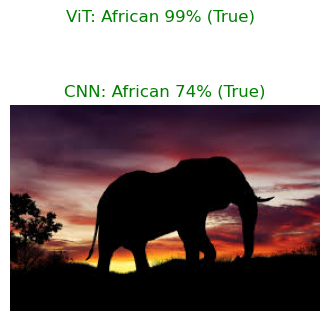

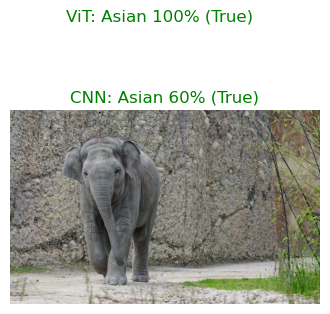

In [86]:
from PIL import Image

# show 2 images where cnn and vit models were correct
plotting_img_by_idx(test_file_list, np.where((y_pred_cnn == y_true) & (y_pred_vit == y_true))[0], n_img=2)

### Show the statistics of the classification misclassification

In [87]:
false_cnn_idx = np.flatnonzero((y_true != y_pred_cnn))
false_vit_idx = np.flatnonzero((y_true != y_pred_vit))

# set intersection give us the commonly shared image id's of the two lists
false_both_idx = list(set(false_cnn_idx) & set(false_vit_idx))

# get idx list for cnn misses but vit hits
cnn_false_vit_hit = set(false_cnn_idx).difference(set(false_both_idx))
# get idx list for vit misses but cnn hits
vit_false_cnn_hit = set(false_vit_idx).difference(set(false_both_idx))

# Printing results
print(f'Total test set cases: {len(y_true)}')
print(
    "Incorrect classifications in {}: {}\nIncorrect classifications in {}: {}\nIncorrectly classified by both Models: {}".format(
        "CNN",
        len(false_cnn_idx),
        "ViT",
        len(false_vit_idx),
        len(false_both_idx)))
print(
    "That means:\n{:4.1f}% (n={}) of the {} misclassifications were correctly classified by the {} and\n{:4.1f}% (n={}) of the {} misclassifications were correctly classified by the {}.".format(
        100 * (1 - (len(false_both_idx) / len(false_cnn_idx))),
        len(cnn_false_vit_hit),
        "CNN", "ViT",
        100 * (1 - (len(false_both_idx) / len(false_vit_idx))),
        len(false_vit_idx) - len(false_both_idx),
        "ViT", "CNN"))

Total test set cases: 188
Incorrect classifications in CNN: 24
Incorrect classifications in ViT: 11
Incorrectly classified by both Models: 8
That means:
66.7% (n=16) of the CNN misclassifications were correctly classified by the ViT and
27.3% (n=3) of the ViT misclassifications were correctly classified by the CNN.


### Show where ViT model was wrong but CNN was correct

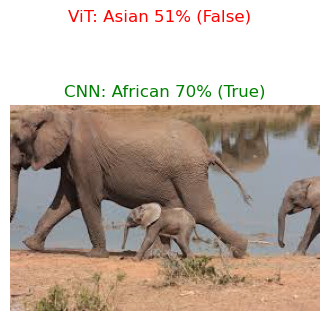

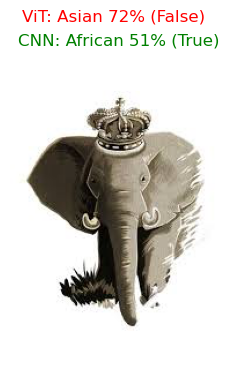

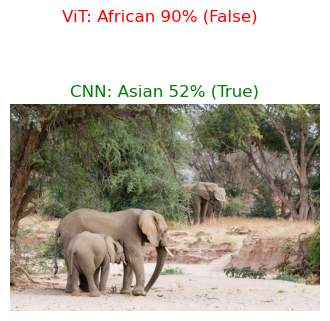

In [88]:
# plot vit misses but cnn hits
plotting_img_by_idx(test_file_list, vit_false_cnn_hit, n_img=len(vit_false_cnn_hit))

### Show 2 images where ViT model was correct but CNN was not

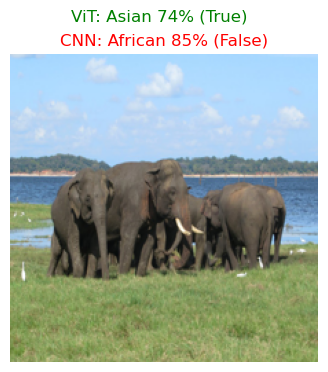

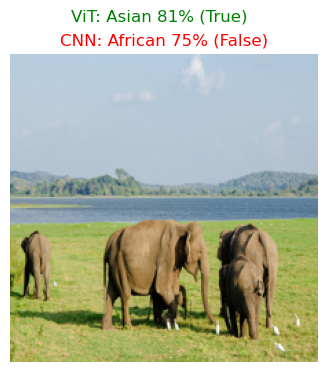

In [89]:
# show where ViT was correct but CNN was not
plotting_img_by_idx(test_file_list, cnn_false_vit_hit, n_img=2, resize=True)

### Show all the images where both models were wrong

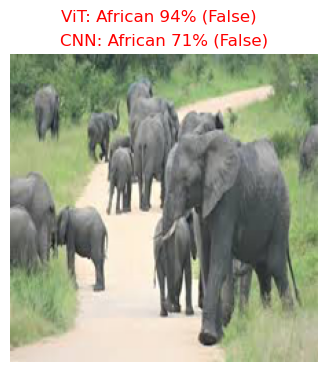

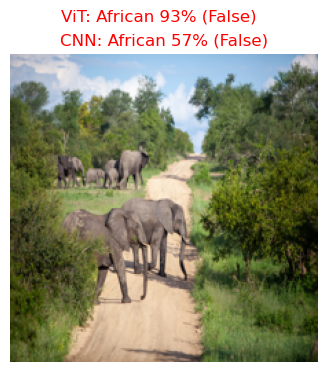

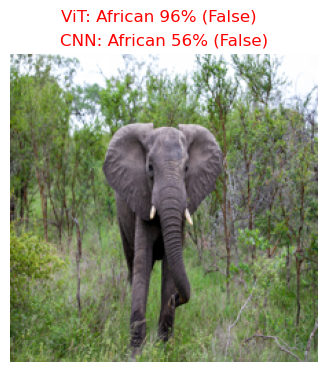

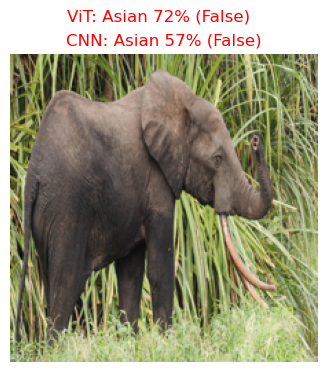

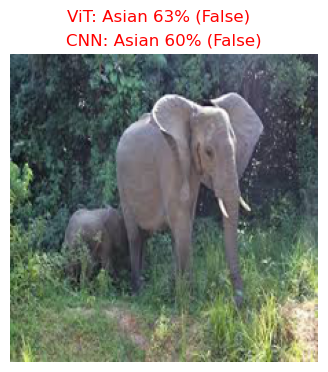

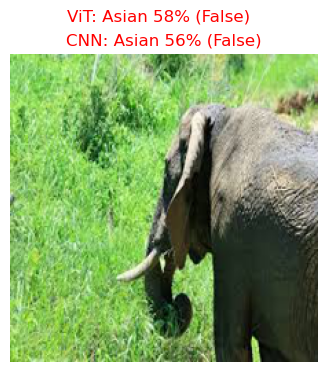

In [90]:
# show the incorrectly classified by both models:
n_img = len(false_both_idx)
plotting_img_by_idx(test_file_list, false_both_idx, n_img=6, resize=True)


### Show the image where CNN has the highest and the lowest confidence

(-0.5, 225.5, 222.5, -0.5)

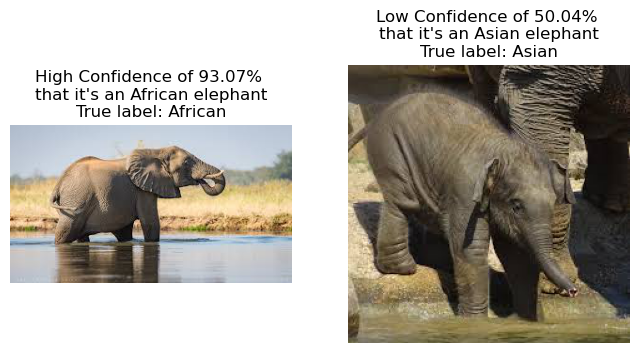

In [91]:
# for the CNN - find one image with low confidence and one with high confidence, save the confidence values
y_prob_cnn_max = np.max(y_prob_cnn, axis=1)

high_conf_value_cnn, high_conf_idx_cnn = np.max(y_prob_cnn_max), np.argmax(y_prob_cnn_max)
low_conf_value_cnn, low_conf_idx_cnn = np.min(y_prob_cnn_max[y_prob_cnn_max > 0.5]), np.argmin(y_prob_cnn_max[y_prob_cnn_max > 0.5])

image_path_high = test_file_list[high_conf_idx_cnn][0]
image_path_low = test_file_list[low_conf_idx_cnn][0]

# plot images
img_high = Image.open(image_path_high)
img_low = Image.open(image_path_low)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_high)
ax[0].set_title("High Confidence of " + str(round(high_conf_value_cnn*100, 2)) + "% \nthat it's an " + label_to_str[y_pred_cnn[high_conf_idx_cnn]] + " elephant" + 
                "\nTrue label: " + label_to_str[y_true[high_conf_idx_cnn]])
ax[0].axis("off")
ax[1].imshow(img_low)
ax[1].set_title("Low Confidence of " + str(round(low_conf_value_cnn*100, 2)) + "% \nthat it's an " + label_to_str[y_pred_cnn[low_conf_idx_cnn]] + " elephant" +
                "\nTrue label: " + label_to_str[y_true[low_conf_idx_cnn]])
ax[1].axis("off")

### CNN activation maps

In [92]:
# model
Resnet = True if best_models[0] == "cnn_resnet50" else False  # optional CNN models are resnet or mobile-net
rank, alpha = 4, 8

if Resnet:
  model = models.resnet50(weights='DEFAULT')
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model.load_state_dict(torch.load(models_save_dir + "/cnn_resnet50_bs_32_ep_20_fe.pth", map_location=device))
  target_layers = [model.layer3, model.layer4, model.avgpool]
else:
  model = models.mobilenet_v3_large(weights='DEFAULT')
  num_ftrs = model.classifier[3].in_features       # 1280
  model.classifier[3] = nn.Linear(num_ftrs, num_classes)
  if DoRA or LoRA:
      use_dora = True if DoRA else False
      replace_linear_with_dora_lora(model, rank, alpha, use_dora=use_dora)
  model.load_state_dict(torch.load(models_save_dir + "/cnn_mobile_net_bs_32_ep_20_fe.pth", map_location=device))
  target_layers = [model.features, model.avgpool]

model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [93]:
# forward each image to the model and predict its class and activation map
images_path = [image_path_high, image_path_low]
input_tensors = []
targets = []
imgs = []
predicted_label_ids = []

for img_path in images_path:
    true_label = img_path.split("/")[-1]
    true_label = true_label.split("\\")[2]
    if true_label == "African":
        true_label_id = 0
    else:
        true_label_id = 1
        
    img = Image.open(img_path)
    
    img = preprocess(img)
    input_tensor = img.cpu()
    input_tensor = transform_val_test(input_tensor)

    img = np.array(Image.open(img_path))
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    imgs.append(img)
    # input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    input_tensors.append(input_tensor)

    output = model(input_tensor)
    output = torch.nn.functional.softmax(output, dim=1)
    
    predicted_label_id = np.argmax(output.cpu().data.numpy())
    if predicted_label_id == 0:
        predicted_label = "African"
        confidence = output.cpu().data.numpy()[0][0] * 100
    else:
        predicted_label = "Asian"
        confidence = output.cpu().data.numpy()[0][1] * 100

    target = [ClassifierOutputTarget(predicted_label_id)]
    targets.append(target)
    predicted_label_ids.append(predicted_label_id)


### Show GradCAM results for images where the CNN model was confident about

CNN was confident in the prediction of the image with high confidence of 0.9306695


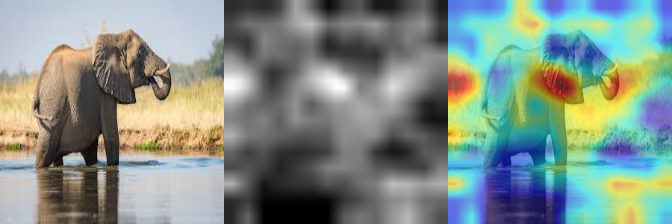

In [94]:
# activation map for an image with high confidence
print("CNN was confident in the prediction of the image with high confidence of " + str(high_conf_value_cnn))

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensors[0], targets=targets[0])
    cam_image = show_cam_on_image(imgs[0], grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255 * grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255 * imgs[0]), cam, cam_image))
Image.fromarray(images)

### Show GradCAM results for images where the CNN model was not confident about

CNN was not confident in the prediction of the image with low confidence of 0.5004382


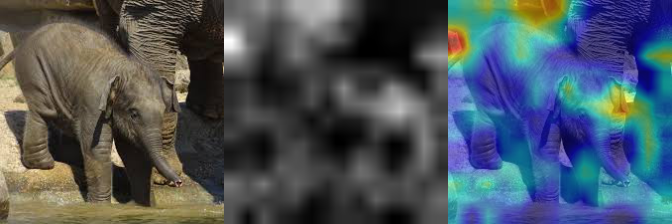

In [95]:
# activation map for an image with low confidence
print("CNN was not confident in the prediction of the image with low confidence of " + str(low_conf_value_cnn))

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensors[1], targets=targets[1])
    cam_image = show_cam_on_image(imgs[1], grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255 * grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255 * imgs[1]), cam, cam_image))
Image.fromarray(images)

### Compare other methods for CNN activation maps for the two images

100%|██████████| 64/64 [00:07<00:00,  8.35it/s]


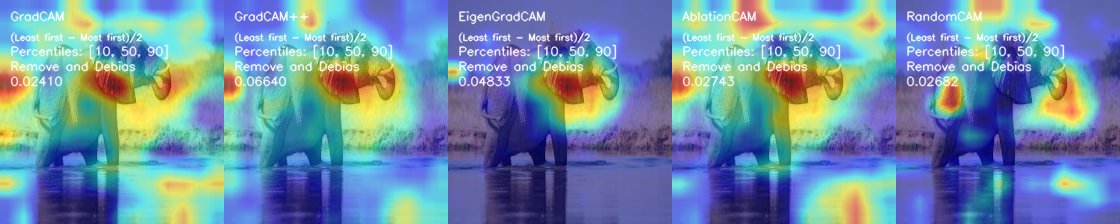

In [96]:
# extension - compare other methods for CNN activation maps

# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor, img, target_layers, eigen_smooth=False, aug_smooth=False, category=0):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(img, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

target_layers = [model.layer3, model.layer4, model.avgpool] if Resnet else [model.features, model.avgpool]

model.cuda()
input_tensors[0] = input_tensors[0].cuda()

benchmark(input_tensors[0], imgs[0], target_layers, eigen_smooth=False, aug_smooth=False, category=predicted_label_ids[0])

100%|██████████| 64/64 [00:07<00:00,  8.04it/s]


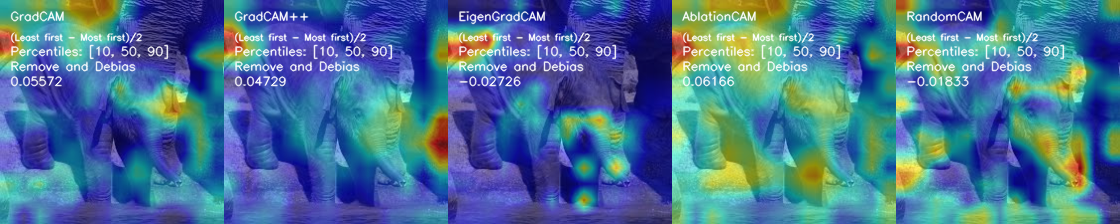

In [97]:
input_tensors[1] = input_tensors[1].cuda()
benchmark(input_tensors[1], imgs[1], target_layers, eigen_smooth=False, aug_smooth=False, category=predicted_label_ids[1])